## Introduction 
----
This notebook presents a comprehensive approach to fraud detection using Predictive Machine Learning Model.

One of the major challenges in applying machine learning (ML) to fraud detection is the presence of highly imbalanced data sets. In many available datasets, majority of transactions are genuine with an extremely small percentage of fraudulent ones.

It is necessary to prevent bad actors from executing fraudulent transactions while ensuring genuine users are not prevented from accessing the payments system. A large number of false positives may translate into bad customer experience and may lead customers to take their business elsewhere.

----


In [1]:
import pandas as pd
import numpy as np 

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('Fraud.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [7]:
# Duplicate Values
print('Data does not have any duplicate value.')
data.duplicated().sum()

Data does not have any duplicate value.


0

In [8]:
print('Data does not have any NULL value.')
data.isnull().sum()

Data does not have any NULL value.


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

We drop 'nameOrig' and 'nameDest' because it is customer ID.

In [9]:
data.rename(columns={'newbalanceOrig':'newbalanceOrg'},inplace=True)
data.drop(labels=['nameOrig','nameDest'],axis=1,inplace=True)

In [10]:
# convert categorical values to numbers
data = data.apply(lambda x: x.astype('category').cat.codes)


In [11]:
data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrg,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,0,3,710400,587897,1157557,0,0,0,0
1,0,3,141767,140919,336044,0,0,0,0
2,0,4,13666,1672,0,0,0,1,0
3,0,1,13666,1672,0,82843,0,1,0
4,0,3,822964,230032,456430,0,0,0,0


# Outlier Identification


In [12]:
skew =data.skew().sort_values(ascending =False )
skew_df= pd.DataFrame({'skew':skew})
skew_df.head(10)


,skew
isFlaggedFraud,630.603629
isFraud,27.779538
oldbalanceOrg,1.594654
newbalanceOrg,1.171838
oldbalanceDest,0.733141
newbalanceDest,0.596814
step,0.375177
type,0.196530
amount,0.191850


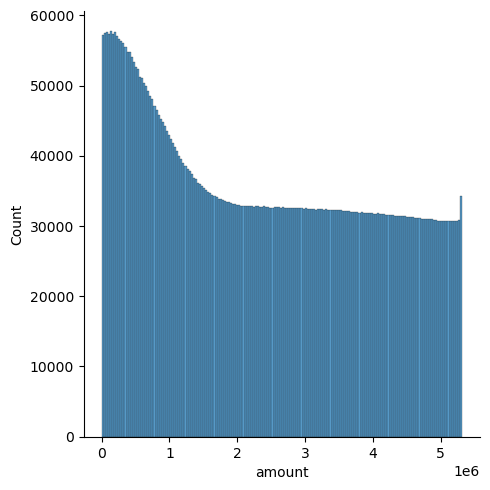

In [13]:
ax = sns.displot(data['amount'])

Our Data is Highly skewed , we should correct it before modeling 

### Kurtosis 
 Kurtosis is one of the two measures that quantify shape of a distribution. **kutosis determine the volume of the outlier**

· It is the sharpness of the peak of a frequency-distribution curve .It is actually the measure of outliers present in the distribution.

· **High kurtosis** in a data set is an indicator that **data has heavy outliers**.

· **Low kurtosis** in a data set is an indicator that **data has lack of outliers.**

In [14]:
kurtosis= pd.DataFrame(data.kurtosis(),columns=['Kurtosis'])
kurtosis.head(8)


,Kurtosis
step,0.329071
type,-1.434577
amount,-1.246017
oldbalanceOrg,1.388436
newbalanceOrg,-0.096553
oldbalanceDest,-0.940136
newbalanceDest,-1.120247
isFraud,769.702982


In [15]:
# kurtosis[(kurtosis['Kurtosis']>=3) |(kurtosis['Kurtosis']<=-3) ].index
# amount_corrected.kurtosis()

### Variance : 
Features with low variance should be eliminated

In [16]:
var= data.var().sort_values(ascending =True )
var_df= pd.DataFrame({'var':var})
var_df.head(10)

,var
isFlaggedFraud,2.514681e-06
isFraud,1.289154e-03
type,1.822815e+00
step,2.025839e+04
oldbalanceOrg,2.404517e+11
newbalanceOrg,6.901669e+11
newbalanceDest,1.410395e+12
oldbalanceDest,1.418158e+12
amount,2.526407e+12


In [17]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

step                  179.00
type                    2.00
amount            2845210.25
oldbalanceOrg      438685.25
newbalanceOrg     1100493.00
oldbalanceDest    2028023.25
newbalanceDest    2141097.25
isFraud                 0.00
isFlaggedFraud          0.00
dtype: float64


In [18]:
# train_num=data.select_dtypes(exclude=['category']) 
# df_out = train_num[~((train_num < (Q1 - 1.5 * IQR))|(train_num > (Q3 + 1.5 * IQR))).any(axis=1)]
# print(df_out.shape)
# del train_num 
# del df_out 

The provided data has the financial transaction data as well as the target variable **isFraud**, which is the actual fraud status of the transaction and **isFlaggedFraud** is the indicator which the simulation is used to flag the transaction using some **threshold value**.

## Multicollinearity

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Feature"] = data.columns
vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]

# Display the VIF for each predictor variable
print(vif_data)

          Feature           VIF
0            step  1.405206e-03
1            type  2.060328e+00
2          amount  1.936757e-10
3   oldbalanceOrg  2.098771e-09
4   newbalanceOrg  2.073808e-09
5  oldbalanceDest -7.486547e-10
6  newbalanceDest  3.408177e-09
7         isFraud  1.028292e+00
8  isFlaggedFraud  1.001993e+00



Since the destination account balances being zero is a strong indicator of fraud, we do not impute the account balance (before the transaction is made) with a statistic or from a distribution with a subsequent adjustment for the amount transacted. 

Doing so would mask this indicator of fraud and make fraudulent transactions appear genuine. 

Instead, below we replace the value of 0 with -1 which will be more useful to a suitable machine-learning (ML) algorithm detecting fraud.


In [20]:
data.loc[(data.oldbalanceDest == 0) & (data.newbalanceDest == 0) & (data.amount != 0), ['oldbalanceDest', 'newbalanceDest']] = -1

The data also has several transactions with zero balances in the originating account both before and after a non-zero amount is transacted. 

In this case, the fraction of such transactions is much smaller in fraudulent (0.3%) compared to genuine transactions (47%). 

Once again, from similar reasoning as above, instead of imputing a numerical value we replace the value of 0 with a null value.


In [21]:
data.loc[(data.oldbalanceOrg == 0) & (data.newbalanceOrg == 0) & (data.amount != 0), ['oldbalanceOrg', 'newbalanceOrg']] = -1

Motivated by the possibility of zero-balances serving to differentiate between fraudulent and genuine transactions, we take the data-imputation, a step further and create 2 new features (columns) recording errors in the originating and destination accounts for each transaction. 

These new features turn out to be important in obtaining the best performance from the ML algorithm that we will finally use.


In [22]:
data['errorBalanceOrig'] = data.newbalanceOrg + data.amount - data.oldbalanceOrg
data['errorBalanceDest'] = data.oldbalanceDest + data.amount - data.newbalanceDest

## Data Analysis

----
Since there is **no missing** , there is no need for data cleaning, but we still need to perform **data analysis** as data contaion huge variation of the value in different columns. Normalization will also imporve the overall accuracy of the machine learning model.

----

Displaying positive correlations. Specify a positive "threshold" to limit the results further.


<AxesSubplot:title={'center':'Feature-correlation (pearson)'}>

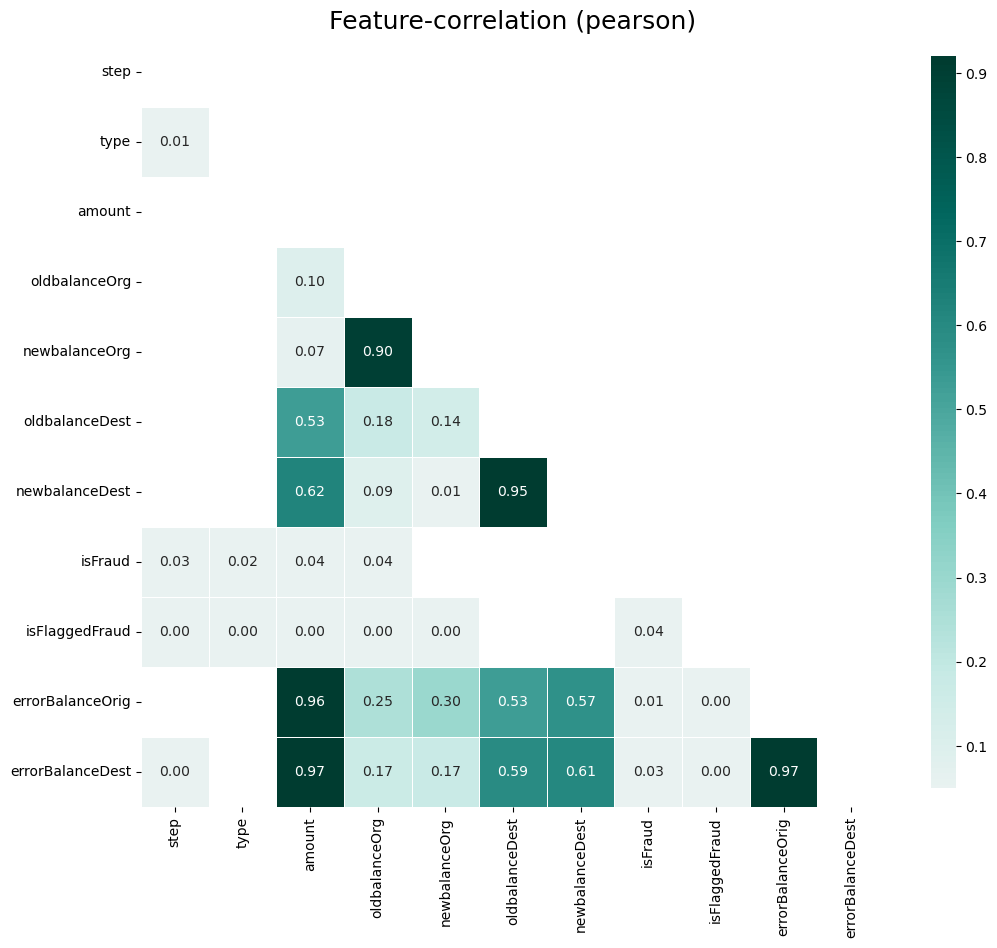

In [23]:
import klib
klib.corr_plot(data, split='pos')

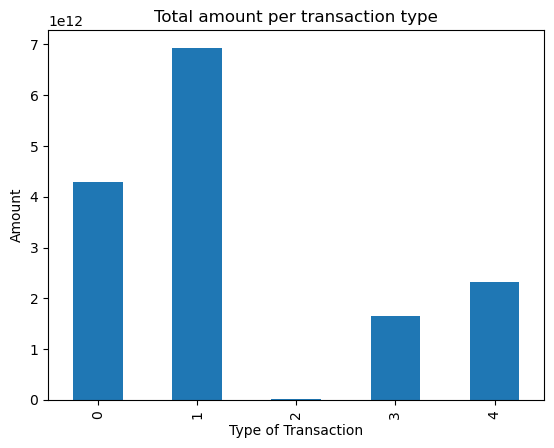

In [24]:
var = data.groupby('type').amount.sum()
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
var.plot(kind='bar')
ax1.set_title("Total amount per transaction type")
ax1.set_xlabel('Type of Transaction')
ax1.set_ylabel('Amount');

In [25]:
data.loc[data.isFraud == 1].type.unique()

array([4, 1], dtype=int8)

The graph above shows that **TRANSFER** and **CASH_OUT** are two most used mode of transaction and we can see that **TRANSFER** and **CASH_OUT** are also the only way in which fraud happen. **Thus we will focus on this type of transactions**.

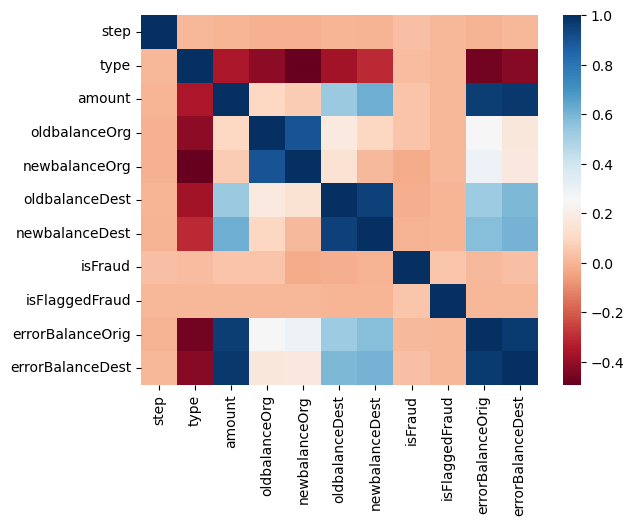

In [26]:
sns.heatmap(data.corr(),cmap='RdBu');

** Things we can conclude from this heatmap: **

* OldbalanceOrg and NewbalanceOrg are highly correlated.
* OldbalanceDest and NewbalanceDest are highly correlated.
* Amount is correlated with isFraud(Target Variable).

There is not much relation between the features, so we need to understand where the relationship between them depends on the type of transaction and amount. To do so, **we need to see the heat map of fraud and nonfraud transactions differently**.

In [27]:
fraud = data.loc[data.isFraud == 1]
nonfraud = data.loc[data.isFraud == 0]

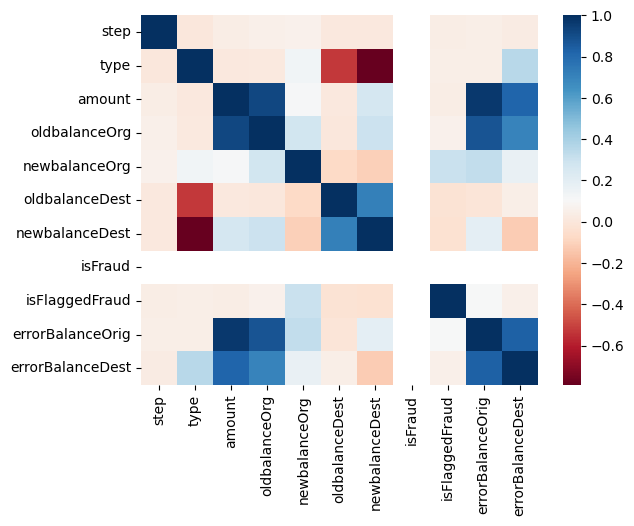

In [28]:
sns.heatmap(fraud.corr(),cmap='RdBu');

There are 2 flags which stand out to me and it's interesting to look onto: isFraud and isFlaggedFraud column. From the hypothesis, **isFraud** is the indicator which indicates the **actual fraud transactions** whereas **isFlaggedFraud** is what the system prevents the transaction due to **some thresholds** being triggered. From the above heatmap we can see that there is some relation between other columns and isFlaggedFraud thus there must be relation between isFraud.

In [29]:
print('The total number of fraud transaction is {}.'.format(data.isFraud.sum()))
print('The total number of fraud transaction which is marked as fraud {}.'.format(data.isFlaggedFraud.sum()))


The total number of fraud transaction is 8213.
The total number of fraud transaction which is marked as fraud 16.


Thus in every 773 transaction there is 1 fraud transaction happening.
Amount lost due to these fraud transaction is $12056415427.


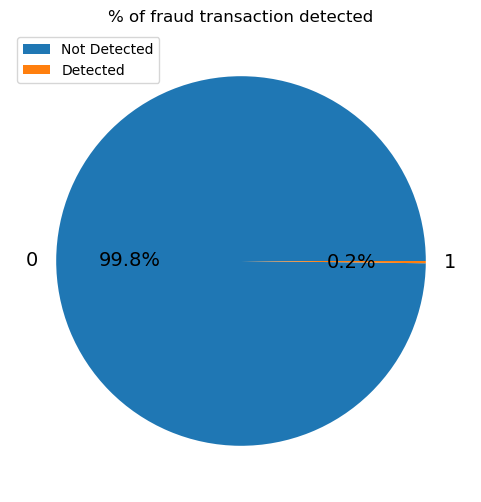

In [30]:
piedata = fraud.groupby(['isFlaggedFraud']).sum()
f, axes = plt.subplots(1,1, figsize=(6,6))
axes.set_title("% of fraud transaction detected")
piedata.plot(kind='pie',y='isFraud',ax=axes, fontsize=14,shadow=False,autopct='%1.1f%%');
axes.set_ylabel('');
plt.legend(loc='upper left',labels=['Not Detected','Detected'])
plt.show()

The plot above clearly shows the **need** for a system which can be **fast** and **reliable** to mark the transaction which is fraud. Since, the current system is letting fraud transaction able to **pass through a system** which is **not labeling them as a fraud**. Some data exploration can be helpful to check for the relation between features.

## Data Segregation

In [31]:
data.drop(['isFlaggedFraud'],axis=1,inplace=True)

In [32]:
X = data.drop(['isFraud'],axis=1)
y = data[['isFraud']]
X_copy=X.copy()

## Machine Learning Model

Used **StratifiedShuffleSplit** to create evenly distibuted Train and Test dataset

In [33]:
from sklearn.metrics import average_precision_score

In [34]:
from sklearn.model_selection import StratifiedShuffleSplit

# Create an instance of StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Loop through the splits and split the data into train and test sets
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


In [35]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=15)
probabilities = clf.fit(X_train, y_train.values.ravel()).predict(X_test)


In [36]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, probabilities)
print(f'`Test accuracy` for Random Forest Classifier: {accuracy}')
print(f'`Average precision score` for Random Forest Classifier: {average_precision_score(y_test,probabilities)}')

`Test accuracy` for Random Forest Classifier: 0.9997548179837865
`Average precision score` for Random Forest Classifier: 0.8112552198152054


**Average precision score for RandomForestClassifier is 81.12%.**

## Conclusion

A company should adopt several prevention measures to ensure that the update process goes smoothly and without any issues. Some of the prevention measures that can be adopted are:

1. **Backup data**: Before updating the infrastructure, it is important to backup all the data that is stored on the servers. This will ensure that in case something goes wrong during the update process, the data can be restored easily.

2. **Test environment**: Companies should create a test environment that is identical to the production environment. This will help in testing the new infrastructure before it is deployed in the production environment.

3. **Rollback plan**: Companies should have a rollback plan in place in case something goes wrong during the update process. This plan should include steps to revert back to the previous infrastructure.

4. **Communication**: Companies should communicate with their employees and customers about the update process and inform them about any changes that they might experience during the update process.

5. **Security**: Companies should ensure that their new infrastructure is secure and that there are no vulnerabilities that can be exploited by hackers.

These are some of the prevention measures that companies can adopt while updating their infrastructure.


**Assuming these actions have been implemented, how would you determine if they work?**

To determine if the implemented actions work, we would need to evaluate the performance of the fraud detection system. An effective fraud detection system should be able to detect fraudulent transactions with high accuracy and efficiency while ensuring genuine users are not prevented from accessing the payments system. 

We can measure the performance of the system by computing metrics like confusion matrix, recall, precision, f1 score, area under precision-recall curve (AUPRC), and area under receiver operating characteristic curve (AUROC). These metrics help us understand how well our model is performing and how it can be improved.

In addition to these metrics, we can also use other techniques like cross-validation and hyperparameter tuning such as regularization parameter and kernel function parameter for SVM to improve the performance of our model. Cross-validation helps us estimate the performance of our model on unseen data while hyperparameter tuning helps us find the best set of hyperparameters for our model.



<a id=6></a>
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:#1777C4; border:0' role="tab" aria-controls="home">
<center>Deploy</center></h3>

The deployment of machine learning models is the process for making models available in production environments, where they can provide predictions to other software systems.

● One of the last stages in the Machine Learning Lifecycle.

**Why is Model Deployment important?**

● To start using a Machine Learning Model, it needs to be effectively deployed into production, so that they can provide predictions to other software systems.

● To maximize the value of the Machine Learning Model, we need to be able to reliably extract the predictions and share them with other systems.


**Production Environment**

● The Production Environment is a real-time setting with running programs and hardware setups that allow the organization’s daily operations.

● It’s the place where the machine learning models is actually available for business use.

● It allows organisations to show clients a “live” service.
This job is done by solid sofware+ml engineer+ devops team


**We have 4 ways to deploy models.**

ML System Architectures:

1. Model embedded in application

2. Served via a dedicated service

3. Model published as data(streaming)

4. Batch prediction (offline process)

